
# Dirty ER

In this notebook we present the pyJedAI approach in the well-known Cora dataset. Dirty ER, is the process of dedeplication of one set.

# How to install?

pyJedAI is an open-source library that can be installed from PyPI.

For more: [pypi.org/project/pyjedai/](https://pypi.org/project/pyjedai/)

In [ ]:
%python --version

In [ ]:
%pip install pyjedai -U

In [ ]:
%pip show pyjedai

Imports

In [1]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs
from pyjedai.evaluation import Evaluation

## Reading the dataset

pyJedAI in order to perfrom needs only the tranformation of the initial data into a pandas DataFrame. Hence, pyJedAI can function in every structured or semi-structured data. In this case Abt-Buy dataset is provided as .csv files. 

<div align="center">
    <img align="center" src="https://github.com/AI-team-UoA/pyJedAI/blob/main/docs/img/reading-process.png?raw=true" width="800" />
</div>


### pyjedai <Data\> module

Data module offers a numpber of options
- Selecting the parameters (columns) of the dataframe, in D1 (and in D2)
- Prints a detailed text analysis
- Stores a hidden mapping of the ids, and creates it if not exists.

In [2]:
from pyjedai.datamodel import Data

d1 = pd.read_csv("./../data/der/cora/cora.csv", sep='|')
gt = pd.read_csv("./../data/der/cora/cora_gt.csv", sep='|', header=None)
attr = ['author', 'title']

Data is the connecting module of all steps of the workflow

In [3]:
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr,
    dataset_name_1="CORA"
)

## Workflow with Block Cleaning Methods

In this notebook we created the bellow architecture:

![workflow1-cora.png](https://github.com/AI-team-UoA/pyJedAI/blob/main/docs/img/workflow1-cora.png?raw=true)



## Block Building

It clusters entities into overlapping blocks in a lazy manner that relies on unsupervised blocking keys: every token in an attribute value forms a key. Blocks are then extracted, possibly using a transformation, based on its equality or on its similarity with other keys.

The following methods are currently supported:

- Standard/Token Blocking
- Sorted Neighborhood
- Extended Sorted Neighborhood
- Q-Grams Blocking
- Extended Q-Grams Blocking
- Suffix Arrays Blocking
- Extended Suffix Arrays Blocking

In [4]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
    ExtendedQGramsBlocking
)

/home/conda/miniconda3/envs/pypi_dependencies/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
bb = SuffixArraysBlocking(suffix_length=2)
blocks = bb.build_blocks(data)

Suffix Arrays Blocking: 100%|██████████| 1295/1295 [00:00<00:00, 7419.94it/s]


In [6]:
_ = bb.evaluate(blocks)

***************************************************************************************************************************
                                         Method:  Suffix Arrays Blocking
***************************************************************************************************************************
Method name: Suffix Arrays Blocking
Parameters: 
	Suffix length: 2
	Maximum Block Size: 53
Runtime: 0.1759 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      4.40% 
	Recall:        75.75%
	F1-score:       8.31%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Block Purging

__Optional step__

Discards the blocks exceeding a certain number of comparisons. 


In [7]:
from pyjedai.block_cleaning import BlockPurging

In [8]:
bp = BlockPurging()
cleaned_blocks = bp.process(blocks, data, tqdm_disable=False)

Block Purging: 100%|██████████| 2842/2842 [00:00<00:00, 127747.12it/s]


In [9]:
bp.report()

Method name: Block Purging
Method info: Discards the blocks exceeding a certain number of comparisons.
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 1378.0
Runtime: 0.0283 seconds


In [10]:
_ = bp.evaluate(cleaned_blocks)

***************************************************************************************************************************
                                         Method:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 1378.0
Runtime: 0.0283 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      4.40% 
	Recall:        75.75%
	F1-score:       8.31%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Block Cleaning

___Optional step___

Its goal is to clean a set of overlapping blocks from unnecessary comparisons, which can be either redundant (i.e., repeated comparisons that have already been executed in a previously examined block) or superfluous (i.e., comparisons that involve non-matching entities). Its methods operate on the coarse level of individual blocks or entities.

In [11]:
from pyjedai.block_cleaning import BlockFiltering

In [12]:
bc = BlockFiltering(ratio=0.9)
blocks = bc.process(blocks, data)

Block Filtering: 100%|██████████| 3/3 [00:00<00:00, 51.87it/s]


In [13]:
_ = bc.evaluate(blocks)

***************************************************************************************************************************
                                         Method:  Block Filtering
***************************************************************************************************************************
Method name: Block Filtering
Parameters: 
	Ratio: 0.9
Runtime: 0.0615 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      5.21% 
	Recall:        74.08%
	F1-score:       9.73%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Comparison Cleaning -  Meta Blocking

___Optional step___

Similar to Block Cleaning, this step aims to clean a set of blocks from both redundant and superfluous comparisons. Unlike Block Cleaning, its methods operate on the finer granularity of individual comparisons.

The following methods are currently supported:

- Comparison Propagation
- Cardinality Edge Pruning (CEP)
- Cardinality Node Pruning (CNP)
- Weighed Edge Pruning (WEP)
- Weighed Node Pruning (WNP)
- Reciprocal Cardinality Node Pruning (ReCNP)
- Reciprocal Weighed Node Pruning (ReWNP)
- BLAST

Most of these methods are Meta-blocking techniques. All methods are optional, but competive, in the sense that only one of them can part of an ER workflow. For more details on the functionality of these methods, see here. They can be combined with one of the following weighting schemes:

- Aggregate Reciprocal Comparisons Scheme (ARCS)
- Common Blocks Scheme (CBS)
- Enhanced Common Blocks Scheme (ECBS)
- Jaccard Scheme (JS)
- Enhanced Jaccard Scheme (EJS)

In [14]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ComparisonPropagation
)

In [15]:
mb = WeightedEdgePruning(weighting_scheme='CBS')
blocks = mb.process(blocks, data)

Weighted Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

Weighted Edge Pruning: 100%|██████████| 1295/1295 [00:00<00:00, 3100.57it/s]


In [16]:
_ = mb.evaluate(blocks)

***************************************************************************************************************************
                                         Method:  Weighted Edge Pruning
***************************************************************************************************************************
Method name: Weighted Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: CBS
Runtime: 0.4188 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     77.91% 
	Recall:        43.85%
	F1-score:      56.12%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [17]:
from pyjedai.matching import EntityMatching

In [18]:
em = EntityMatching(
    metric='jaccard',
    similarity_threshold=0.0
)

pairs_graph = em.predict(blocks, data)

Entity Matching (jaccard, white_space_tokenizer):  10%|█         | 74/727 [00:00<00:00, 722.21it/s]

Entity Matching (jaccard, white_space_tokenizer): 100%|██████████| 727/727 [00:01<00:00, 393.01it/s]


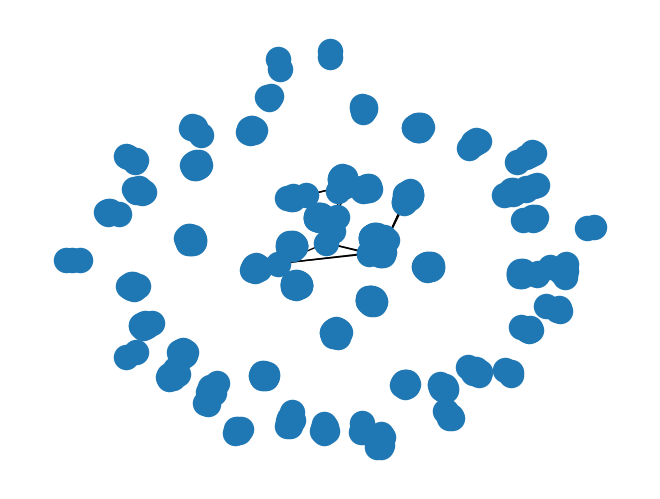

In [19]:
draw(pairs_graph)

In [20]:
_ = em.evaluate(pairs_graph)

***************************************************************************************************************************
                                         Method:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Metric: jaccard
	Attributes: None
	Similarity threshold: 0.0
	Tokenizer: white_space_tokenizer
	Vectorizer: None
	Qgrams: 1
Runtime: 1.8509 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     77.91% 
	Recall:        43.85%
	F1-score:      56.12%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Experimenting with the attributes selected in Matching step

Giving a `list` of attributes (subset of initial), the user can experiment with the attributes that are selected in the matching step. The user can select the attributes that are used in the matching step, and the attributes that are used in the blocking step.

In [21]:
em = EntityMatching(
    metric='jaccard',
    similarity_threshold=0.0,
    attributes=['author']
)

authors_pairs_graph = em.predict(blocks, data)
_ = em.evaluate(authors_pairs_graph)

Entity Matching (jaccard, white_space_tokenizer): 100%|██████████| 727/727 [00:00<00:00, 864.19it/s] 


***************************************************************************************************************************
                                         Method:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Metric: jaccard
	Attributes: ['author']
	Similarity threshold: 0.0
	Tokenizer: white_space_tokenizer
	Vectorizer: None
	Qgrams: 1
Runtime: 0.8427 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     77.53% 
	Recall:        41.53%
	F1-score:      54.09%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Giving weights as `dict`. Adding a weight factor to each attribute. 

In [22]:
weights = {
    'author': 0.2,
    'title': 0.8
}

em = EntityMatching(
    metric='jaccard',
    similarity_threshold=0.0,
    attributes=weights
)

weights_pairs_graph = em.predict(blocks, data)
_ = em.evaluate(weights_pairs_graph)

Entity Matching (jaccard, white_space_tokenizer):  11%|█         | 80/727 [00:00<00:00, 786.33it/s]

Entity Matching (jaccard, white_space_tokenizer): 100%|██████████| 727/727 [00:01<00:00, 477.20it/s]


***************************************************************************************************************************
                                         Method:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Metric: jaccard
	Attributes: {'author': 0.2, 'title': 0.8}
	Similarity threshold: 0.0
	Tokenizer: white_space_tokenizer
	Vectorizer: None
	Qgrams: 1
Runtime: 1.5248 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     77.91% 
	Recall:        43.85%
	F1-score:      56.12%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### How to set a valid similarity threshold?

Configure similariy threshold with a Grid-Search or with an Optuna search. Also pyJedAI provides some visualizations on the distributions of the scores.

For example with a classic histogram:


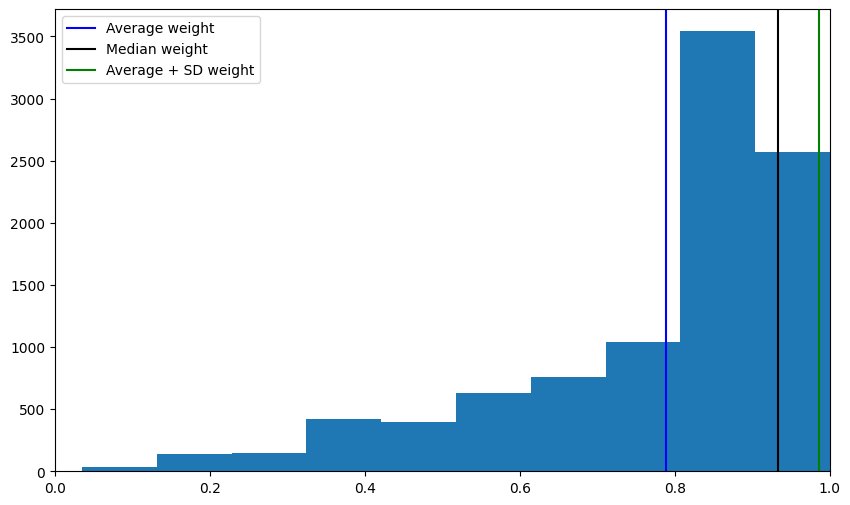

In [23]:
em.plot_distribution_of_all_weights()

Or with a range 0.1 from 0.0 to 1.0 grouping:

Distribution-% of predicted scores:  [0.175783269568814, 1.199462309998966, 1.5303484644814394, 3.732809430255403, 3.898252507496639, 6.545341743356427, 8.168751938786063, 8.334195016027298, 34.8361079516079, 17.79547099576052]


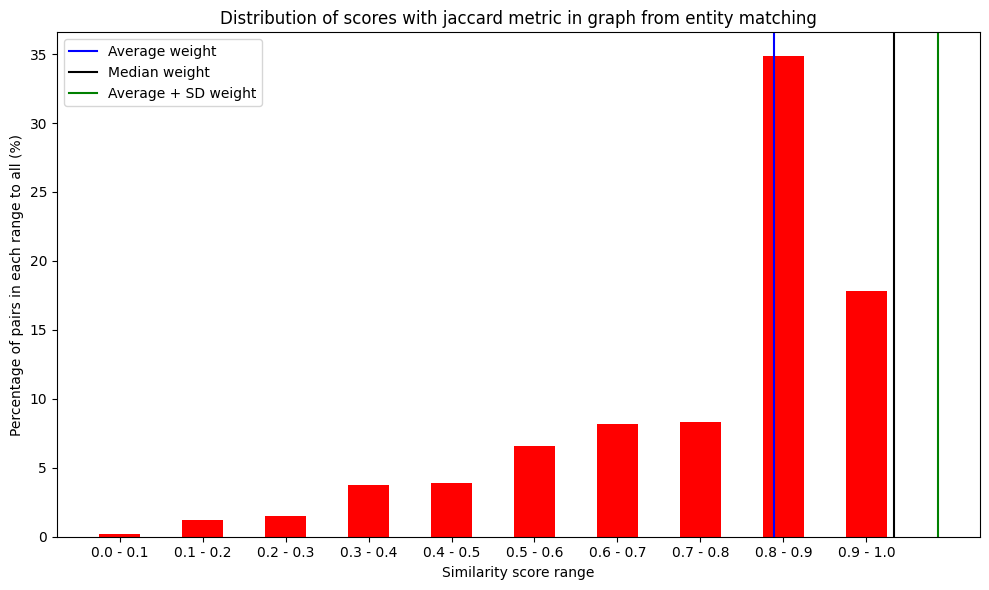

In [24]:
em.plot_distribution_of_scores()

## Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [25]:
from pyjedai.clustering import ConnectedComponentsClustering

In [26]:
ec = ConnectedComponentsClustering()
clusters = ec.process(pairs_graph, data, similarity_threshold=0.3)

In [27]:
_ = ec.evaluate(clusters)

***************************************************************************************************************************
                                         Method:  Connected Components Clustering
***************************************************************************************************************************
Method name: Connected Components Clustering
Parameters: 
	Similarity Threshold: 0.3
Runtime: 0.0396 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     76.45% 
	Recall:        43.99%
	F1-score:      55.85%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Workflow with Similarity Joins

In this notebook we created the bellow archtecture:

![workflow2-cora.png](https://github.com/AI-team-UoA/pyJedAI/blob/main/documentation/workflow2-cora.png?raw=true)



## Data Reading

Data is the connecting module of all steps of the workflow

In [28]:
from pyjedai.datamodel import Data
d1 = pd.read_csv("./../data/der/cora/cora.csv", sep='|')
gt = pd.read_csv("./../data/der/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

## Similarity Joins

In [29]:
from pyjedai.joins import EJoin, TopKJoin

In [30]:
join = EJoin(similarity_threshold = 0.5,
             metric = 'jaccard',
             tokenization = 'qgrams_multiset',
             qgrams = 2)

g = join.fit(data)

EJoin (jaccard):   0%|          | 0/1295 [00:00<?, ?it/s]

EJoin (jaccard): 2590it [00:21, 120.18it/s]              


In [31]:
_ = join.evaluate(g)

***************************************************************************************************************************
                                         Method:  EJoin
***************************************************************************************************************************
Method name: EJoin
Parameters: 
	similarity_threshold: 0.5
	metric: jaccard
	tokenization: qgrams_multiset
	qgrams: 2
Runtime: 21.6151 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     65.80% 
	Recall:        93.03%
	F1-score:      77.08%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [32]:
topk_join = TopKJoin(K=20,
             metric = 'jaccard',
             tokenization = 'qgrams',
             qgrams = 3)

g = topk_join.fit(data)

Top-K Join (jaccard):   0%|          | 0/1295 [00:00<?, ?it/s]

Top-K Join (jaccard): 2590it [00:15, 172.51it/s]              


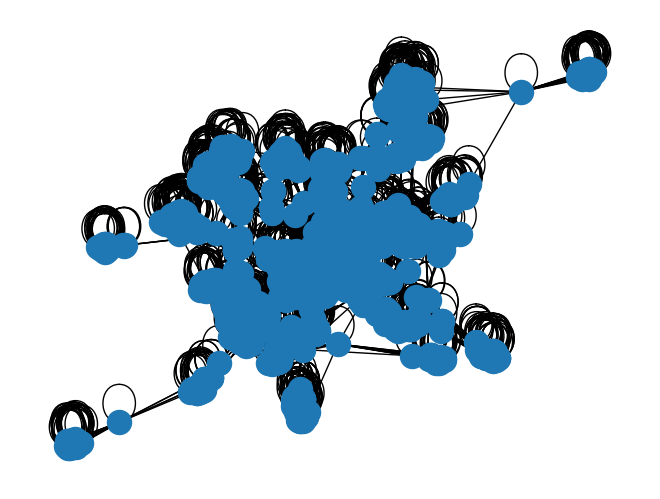

In [33]:
draw(g)

In [34]:
topk_join.evaluate(g)

***************************************************************************************************************************
                                         Method:  Top-K Join
***************************************************************************************************************************
Method name: Top-K Join
Parameters: 
	similarity_threshold: 0.25547445255474455
	K: 20
	metric: jaccard
	tokenization: qgrams
	qgrams: 3
Runtime: 15.0497 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     58.34% 
	Recall:        63.75%
	F1-score:      60.92%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 58.340434597358325,
 'Recall %': 63.74534450651769,
 'F1 %': 60.923248053392655,
 'True Positives': 10954,
 'False Positives': 7822,
 'True Negatives': 814451.0,
 'False Negatives': 6230}

## Entity Clustering

In [35]:
from pyjedai.clustering import ConnectedComponentsClustering

In [36]:
ccc = ConnectedComponentsClustering()

clusters = ccc.process(g, data)

In [37]:
_ = ccc.evaluate(clusters)

***************************************************************************************************************************
                                         Method:  Connected Components Clustering
***************************************************************************************************************************
Method name: Connected Components Clustering
Parameters: 
	Similarity Threshold: None
Runtime: 0.1237 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      2.05% 
	Recall:       100.00%
	F1-score:       4.02%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


<hr>
<div align="right">
K. Nikoletos, J. Maciejewski, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>